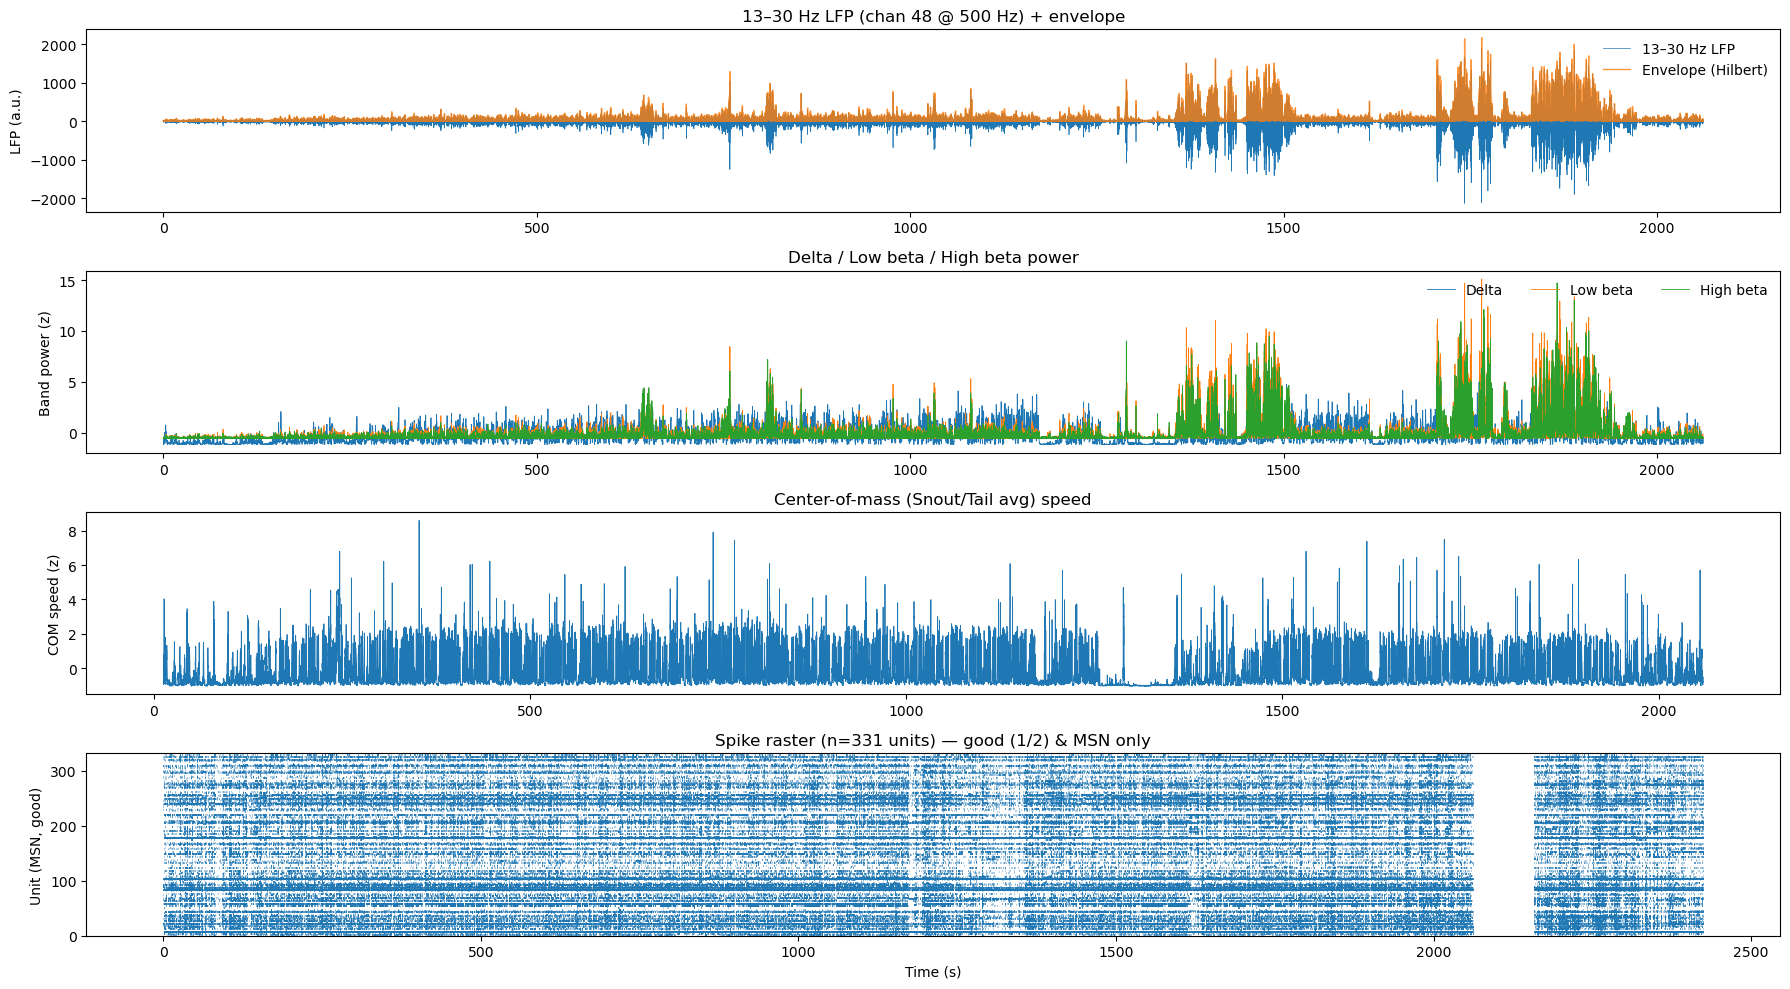

Plotted 331 MSN good units. LFP samples: 1030779, LFP time span ~2061.6s. DLC rows: 184076, window=None


In [ ]:
# -*- coding: utf-8 -*-
"""
Four-panel figure:
(1) 13–30 Hz band-passed LFP (chan48, 500 Hz) + Hilbert envelope
(2) Delta, Low-beta, High-beta band power
(3) Center-of-mass (Snout/Tail average) speed from DLC
(4) Spike raster: good (label 1 or 2) MSN units only
"""

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from pathlib import Path

# SciPy is used for filtering/envelopes; install if needed: pip install scipy
from scipy.signal import butter, filtfilt, hilbert

# ----------------------------
# Paths (edit if your mount differs)
# ----------------------------
BASE = Path("/Volumes/Extreme SSD/Neuropixels/9153_02072025_tagging_g0/9153_02072025_tagging_g0_imec0/kilosort4")
LFP_PATH = BASE / "lfp_chan48_500Hz.npy"
BANDS_NPZ = BASE / "alignment_amp_tailAccel_02072025.npz"
SPIKE_SECONDS_PATH = BASE / "spike_seconds_adj.npy"
QMETRICS_TSV = (BASE.parent / "kilosort4qMetrics" / "templates._bc_unit_labels.tsv")
CLASS_CSV = BASE / "unit_classification_rulebased.csv"
STROBE_PATH = BASE / "strobe_seconds.npy"
SPIKE_UNIT_IDS_PATH = BASE / "spike_clusters.npy"

DLC_H5 = Path("/Volumes/Extreme SSD/Neuropixels/DLC/9153/9153_Day13_4rewards2025-02-07T13_43_04DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210.h5")

# ----------------------------
# Config
# ----------------------------
FS_LFP = 500.0                          # Hz (for lfp_chan48_500Hz.npy)
BP = (13.0, 30.0)                       # band-pass for beta
SMOOTH_SPEED_SEC = 0.10                 # ~100 ms moving-average on speed (DLC)
STANDARDIZE_BANDS = True                # z-score delta/low-beta/high-beta for plotting
STANDARDIZE_SPEED = True                # z-score COM speed for plotting
T_WINDOW = None                         # e.g., (200.0, 240.0) in seconds to zoom; or None for full session
SAVE_FIG = False
FIG_OUT = BASE / "figure_02072025_lfp_bands_comspeed_raster.png"

# ----------------------------
# Helpers
# ----------------------------
def zscore(x):
    x = np.asarray(x, dtype=float)
    m = np.nanmean(x)
    s = np.nanstd(x)
    if s == 0 or not np.isfinite(s):
        s = 1.0
    return (x - m) / s

def bandpass_filt(x, fs, lo, hi, order=4):
    nyq = fs * 0.5
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x)

def moving_average(x, win_samples):
    if win_samples <= 1:
        return x
    kernel = np.ones(win_samples, dtype=float) / win_samples
    return np.convolve(x, kernel, mode="same")

def build_dlc_timebase_from_strobe(strobe_seconds, n_rows):
    # Interpolate *evenly* from first → last strobe to DLC rows
    return np.linspace(strobe_seconds[0], strobe_seconds[-1], n_rows)

def extract_xy_from_dlc(df, bodypart, scorer=None):
    """
    DLC pandas HDF is usually MultiIndex (scorer, bodypart, coord).
    Returns x,y arrays (float). Raises if missing.
    """
    if isinstance(df.columns, pd.MultiIndex):
        if scorer is None:
            scorer = sorted(set([c[0] for c in df.columns]))[0]
        cols = ( (scorer, bodypart, "x"), (scorer, bodypart, "y") )
        if all(c in df.columns for c in cols):
            x = df[cols[0]].astype(float).to_numpy()
            y = df[cols[1]].astype(float).to_numpy()
            return x, y
        else:
            raise KeyError(f"Bodypart {bodypart} with scorer {scorer} missing x/y columns.")
    else:
        # Single-level fallback (rare)
        xcol = f"{bodypart}_x"
        ycol = f"{bodypart}_y"
        x = df[xcol].astype(float).to_numpy()
        y = df[ycol].astype(float).to_numpy()
        return x, y

def load_spikes_times_and_units(times_path, units_path):
    times = np.load(times_path, allow_pickle=True)
    units = np.load(units_path, allow_pickle=True)
    assert times.ndim == 1 and units.ndim == 1 and len(times) == len(units), \
        "Spike times and unit-ids must be 1D and same length"
    # Group to dict {unit_id: times[]}
    spike_map = {}
    for u, t in zip(units.astype(int), times.astype(float)):
        if np.isfinite(t):
            if u not in spike_map:
                spike_map[u] = []
            spike_map[u].append(t)
    # Convert lists to sorted arrays
    for u in list(spike_map.keys()):
        spike_map[u] = np.sort(np.asarray(spike_map[u], dtype=float))
    return spike_map

def robust_spike_container_load(spike_path):
    """
    Tries to interpret spike_seconds_adj.npy as:
      - dict: {unit_id: 1D array of spike times}
      - object array: list-like where index == unit_id
      - structured array with 'unit' and 'time' fields
    Returns: dict[int -> np.ndarray of spike times]
    """
    arr = np.load(spike_path, allow_pickle=True)
    spike_map = {}

    # Dict case
    if isinstance(arr, dict):
        for k, v in arr.items():
            try:
                uid = int(k)
            except Exception:
                continue
            spike_map[uid] = np.asarray(v, dtype=float)
        return spike_map

    # Structured fields case
    for fields in (("unit", "time"), ("cluster", "time"), ("unit_id", "time")):
        if isinstance(arr, np.ndarray) and arr.dtype.names is not None:
            if all(f in arr.dtype.names for f in fields):
                units = arr[fields[0]]
                times = arr[fields[1]]
                for u, t in zip(units, times):
                    spike_map[int(u)] = np.atleast_1d(np.asarray(t, dtype=float))
                return spike_map

    # Object or numeric array case
    if isinstance(arr, np.ndarray) and arr.dtype == object:
        # assume index == unit_id
        for uid, v in enumerate(arr):
            if v is None:
                continue
            spike_map[int(uid)] = np.asarray(v, dtype=float).ravel()
        return spike_map

    # Fallback: 2D pairs [N,2] (unit_id, time)
    if isinstance(arr, np.ndarray) and arr.ndim == 2 and arr.shape[1] == 2:
        for uid, t in arr:
            spike_map[int(uid)] = np.append(spike_map.get(int(uid), np.array([])), float(t))
        return spike_map

    raise ValueError("Unrecognized spike_seconds_adj.npy format; please inspect file.")

def limit_range(t, *ys, t_window=None):
    if t_window is None:
        return (t,) + ys
    t0, t1 = t_window
    m = (t >= t0) & (t <= t1)
    out = [t[m]]
    for y in ys:
        if y is None:
            out.append(None)
        else:
            # Try broadcast along first dim if shapes match
            if y.ndim == 1 and y.shape[0] == t.shape[0]:
                out.append(y[m])
            else:
                out.append(y)
    return tuple(out)

# ----------------------------
# 1) LFP 13–30 Hz with envelope
# ----------------------------
lfp = np.load(LFP_PATH).astype(float)  # 1D, 500 Hz
lfp_filt = bandpass_filt(lfp, FS_LFP, BP[0], BP[1])
lfp_env = np.abs(hilbert(lfp_filt))

# Time for LFP: we will anchor to band NPZ 'time_lfp' if length matches or rescale
bands = np.load(BANDS_NPZ)
time_lfp = bands["time_lfp"].astype(float)

if len(time_lfp) == len(lfp):
    t_lfp = time_lfp
else:
    # Rescale to same span as band time (assumes both cover same session)
    t_lfp = np.linspace(time_lfp[0], time_lfp[-1], len(lfp))

# ----------------------------
# 2) Band power (delta/low-beta/high-beta)
# ----------------------------
def get_npz_key(npz, candidates):
    for k in candidates:
        if k in npz.files:
            return k
    raise KeyError(f"None of keys {candidates} found in NPZ.")

delta_key = get_npz_key(bands, ["delta_amp", "delta", "delta_power"])
blo_key   = get_npz_key(bands, ["beta_low_amp", "low_beta_amp", "beta_low"])
bhi_key   = get_npz_key(bands, ["beta_high_amp", "high_beta_amp", "beta_high"])

delta = bands[delta_key].astype(float)
beta_low = bands[blo_key].astype(float)
beta_high = bands[bhi_key].astype(float)

if STANDARDIZE_BANDS:
    delta_p = zscore(delta)
    blo_p = zscore(beta_low)
    bhi_p = zscore(beta_high)
else:
    delta_p, blo_p, bhi_p = delta, beta_low, beta_high

# ----------------------------
# 3) Center-of-mass speed from DLC
# ----------------------------
dlc_df = pd.read_hdf(DLC_H5)
n_rows = len(dlc_df)
strobe = np.load(STROBE_PATH).astype(float)
t_dlc = build_dlc_timebase_from_strobe(strobe, n_rows)
dt_dlc = float(np.median(np.diff(t_dlc)))

# Try to read Snout & Tail; if Tail variants missing, try common alternates
snout_x, snout_y = extract_xy_from_dlc(dlc_df, "Snout")
try:
    tail_x, tail_y = extract_xy_from_dlc(dlc_df, "Tail")
except Exception:
    for alt in ["TailBase", "Tailbase", "TailTip", "Tail_tip"]:
        try:
            tail_x, tail_y = extract_xy_from_dlc(dlc_df, alt)
            break
        except Exception:
            pass

# Clean missing and interpolate if needed
def clean_interp(a):
    a = np.asarray(a, dtype=float)
    a[a <= -0.5] = np.nan
    return pd.Series(a).interpolate(limit_direction="both").to_numpy()

snout_x, snout_y = clean_interp(snout_x), clean_interp(snout_y)
tail_x, tail_y   = clean_interp(tail_x),   clean_interp(tail_y)

com_x = 0.5 * (snout_x + tail_x)
com_y = 0.5 * (snout_y + tail_y)

vx = np.gradient(com_x, t_dlc)
vy = np.gradient(com_y, t_dlc)
speed = np.sqrt(vx**2 + vy**2)

# Smooth ~100 ms
win = max(3, int(round(SMOOTH_SPEED_SEC / max(dt_dlc, 1e-9))))
if win % 2 == 0:
    win += 1
speed_s = moving_average(speed, win)

speed_plot = zscore(speed_s) if STANDARDIZE_SPEED else speed_s

# ----------------------------
# 4) Spike raster (good units & MSN only)
# ----------------------------
# Good labels (1/2)
qm = pd.read_csv(QMETRICS_TSV, sep="\t")
good_units = set(qm["unitType"].isin([1, 2]).index.astype(int).tolist())

# MSN filter
uclass = pd.read_csv(CLASS_CSV)
msn_units = set(uclass.loc[uclass["cell_type"].str.upper()=="MSN", "unit_id"].astype(int).tolist())

keep_units = sorted(list(good_units & msn_units))
if len(keep_units) == 0:
    print("WARNING: No overlap between good units and MSN units; raster will be empty.")

spike_map = load_spikes_times_and_units(SPIKE_SECONDS_PATH, SPIKE_UNIT_IDS_PATH)

# Build ordered list of (unit_id, spike_times) with filter applied
spikes_kept = []
for uid in keep_units:
    st = spike_map.get(uid, None)
    if st is None:
        continue
    st = np.asarray(st, dtype=float).ravel()
    st = st[np.isfinite(st)]
    spikes_kept.append((uid, np.sort(st)))

# ----------------------------
# Optional: limit to time window
# ----------------------------
t_lfp_plot, lfp_filt_plot, lfp_env_plot = limit_range(t_lfp, lfp_filt, lfp_env, t_window=T_WINDOW)
time_lfp_plot, delta_p_plot, blo_p_plot, bhi_p_plot = limit_range(time_lfp, delta_p, blo_p, bhi_p, t_window=T_WINDOW)
t_dlc_plot, speed_plot = limit_range(t_dlc, speed_plot, t_window=T_WINDOW)

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(4, 1, figsize=(18, 10), sharex=False)
ax0, ax1, ax2, ax3 = axes

# (1) LFP bandpassed + envelope
ax0.plot(t_lfp_plot, lfp_filt_plot, lw=0.5, label="13–30 Hz LFP")
ax0.plot(t_lfp_plot, lfp_env_plot, lw=1.0, alpha=0.8, label="Envelope (Hilbert)")
ax0.set_ylabel("LFP (a.u.)")
ax0.set_title("13–30 Hz LFP (chan 48 @ 500 Hz) + envelope")
ax0.legend(loc="upper right", frameon=False)

# (2) Delta / Low-beta / High-beta power
ax1.plot(time_lfp_plot, delta_p_plot, lw=0.6, label="Delta")
ax1.plot(time_lfp_plot, blo_p_plot, lw=0.6, label="Low beta")
ax1.plot(time_lfp_plot, bhi_p_plot, lw=0.6, label="High beta")
ax1.set_ylabel("Band power (z)" if STANDARDIZE_BANDS else "Band power")
ax1.set_title("Delta / Low beta / High beta power")
ax1.legend(loc="upper right", ncol=3, frameon=False)

# (3) Center-of-mass speed (Snout/Tail average)
ax2.plot(t_dlc_plot, speed_plot, lw=0.6)
ax2.set_ylabel("COM speed (z)" if STANDARDIZE_SPEED else "COM speed (px/s)")
ax2.set_title("Center-of-mass (Snout/Tail avg) speed")

# (4) Spike raster
# If a time window is set, restrict spikes; else use all times
t0t1 = T_WINDOW
for row, (uid, st) in enumerate(spikes_kept, start=1):
    if t0t1 is not None:
        m = (st >= t0t1[0]) & (st <= t0t1[1])
        st_plot = st[m]
    else:
        st_plot = st
    if st_plot.size:
        ax3.vlines(st_plot, row-0.4, row+0.4, linewidth=0.5)
ax3.set_ylim(0, max(1, len(spikes_kept))+1)
ax3.set_ylabel("Unit (MSN, good)")
ax3.set_xlabel("Time (s)")
ax3.set_title(f"Spike raster (n={len(spikes_kept)} units) — good (1/2) & MSN only")

# Align x-limits if a window is set
if T_WINDOW is not None:
    for ax in axes:
        ax.set_xlim(T_WINDOW)

plt.tight_layout()
if SAVE_FIG:
    plt.savefig(FIG_OUT, dpi=200, bbox_inches="tight")
plt.show()

print(f"Plotted {len(spikes_kept)} MSN good units. "
      f"LFP samples: {len(lfp)}, LFP time span ~{t_lfp[-1]-t_lfp[0]:.1f}s. "
      f"DLC rows: {len(t_dlc)}, window={T_WINDOW}")